### DeepSeekv2 is a decoder-like transformer architecture

paper: https://arxiv.org/pdf/2405.04434

it incorporates 2 key-features:
- Multi-Head-latent self-attention
- Mixture-of-Experts layer from DeepSeekMoE paper: https://arxiv.org/pdf/2401.06066

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from math import sqrt

### basic architecture:

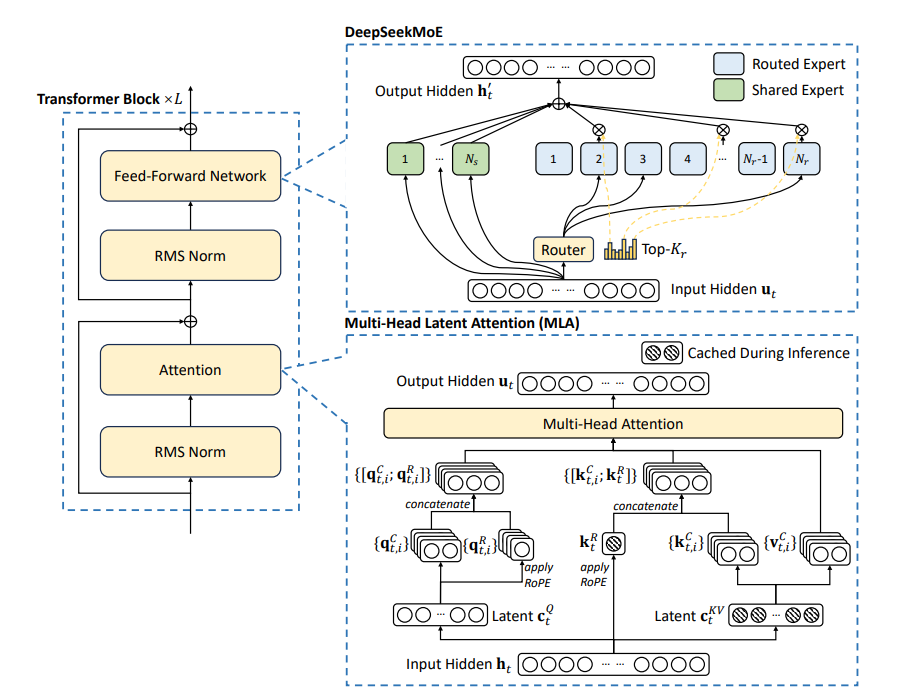

we'll build 5 main classes:

- `RoPE`
- `MLA` (encapsulates `RoPE`)
- `RMSNorm`
- `MoE`
- `DeepSeekV2` (Encapsulates all the classes above)

In [56]:
## dimensions

batch_size = 8
sequence_len = 10
embedding_dim = 32
vocab_size = 10000

# rope params
theta = 3

# mla dimensions
latent_dim = 16
num_heads = 4

# RMS norm params


# MoE dimensions
num_experts = 14
m = 2
k = 3
dim_experts = embedding_dim//m
num_shared_exp = 3

#### 1. `MLA` class

In [4]:
# RoPE and mla direct computation attempt

input_sentence = torch.rand([batch_size,
                             sequence_len,
                             embedding_dim], dtype=torch.float32)

input_sentence.shape

torch.Size([8, 10, 32])

In [4]:
pos_vec = torch.arange(0, sequence_len, 1, dtype=torch.int8)
dims_vec = torch.arange(0, embedding_dim//2, 1, dtype=torch.int8)

# expand pos and dims vec
unity = torch.ones([sequence_len, embedding_dim//2])
pos = pos_vec.reshape(sequence_len, 1) * unity
dims = dims_vec.reshape(1, embedding_dim//2) * unity


theta = pos / 10000**(2*dims / embedding_dim)

theta.shape

torch.Size([10, 16])

In [5]:
# extract sine and cossine
sin, cos = torch.sin(theta), torch.cos(theta)

In [6]:
# reshape input
pairs = input_sentence.reshape(batch_size, sequence_len, embedding_dim//2, 2)
pairs.shape

torch.Size([8, 10, 16, 2])

In [7]:
out1 = cos * pairs[:, :, :, 0] - sin * pairs[:, :, :, 1]
out2 = sin * pairs[:, :, :, 0] + cos * pairs[:, :, :, 1] 

out1.shape, out2.shape

out = torch.cat((out1, out2), dim=-1)
out.shape

torch.Size([8, 10, 32])

In [3]:
# bulding RoPE class

class RoPE(nn.Module):
    def __init__(self, sequence_len, embedding_dim):
        super(RoPE, self).__init__()

        self.sequence_len = sequence_len
        self.embedding_dim = embedding_dim

        self.pos_vec = torch.arange(0, sequence_len, 1, dtype=torch.float32)
        self.dims_vec = torch.arange(0, embedding_dim//2, 1, dtype=torch.float32)

        self.unity = torch.ones([sequence_len, embedding_dim//2])
        self.pos = self.pos_vec.reshape(sequence_len, 1) * self.unity
        self.dims = self.dims_vec.reshape(1, embedding_dim//2) * self.unity

        self.theta = self.pos / 10000**(2*self.dims / embedding_dim)
        self.sin, self.cos = torch.sin(self.theta), torch.cos(self.theta)

    def forward(self, x):
        batch_size= x.size()[0]
        pairs = x.reshape(batch_size, self.sequence_len, self.embedding_dim//2, 2)
        out1 = self.cos * pairs[:, :, :, 0] - self.sin * pairs[:, :, :, 1]
        out2 = self.sin * pairs[:, :, :, 0] + self.cos * pairs[:, :, :, 1]
        out = torch.stack((out1, out2), dim=-1)
        return out.reshape(batch_size, self.sequence_len, self.embedding_dim)


In [5]:
rope = RoPE(10, 32)

rope(input_sentence)[0][0]

tensor([0.4112, 0.4868, 0.7399, 0.5523, 0.4524, 0.6234, 0.2652, 0.6635, 0.3116,
        0.6307, 0.1086, 0.8983, 0.8498, 0.9567, 0.9960, 0.4217, 0.3363, 0.6311,
        0.3067, 0.9307, 0.7569, 0.5160, 0.5900, 0.3073, 0.7976, 0.5537, 0.6555,
        0.0538, 0.3652, 0.1107, 0.7599, 0.8419])

In [11]:
# mla direct computation

input_sentence.shape

torch.Size([8, 10, 32])

In [12]:
# latent spaces
w_latent_query = torch.rand([sequence_len, latent_dim], dtype=torch.float32)
w_latent_keyvalue = torch.rand([sequence_len, latent_dim], dtype=torch.float32)


cq = torch.einsum("btd,tl->btl", input_sentence, w_latent_query)

ckv = torch.einsum("btd,tl->btl", input_sentence, w_latent_keyvalue)

cq.shape, ckv.shape

(torch.Size([8, 10, 16]), torch.Size([8, 10, 16]))

In [13]:
# upper reconstruction
w_upper_query = torch.rand([sequence_len, embedding_dim], dtype=torch.float32)
w_upper_key = torch.rand([sequence_len, embedding_dim], dtype=torch.float32)
w_upper_value = torch.rand([sequence_len, embedding_dim], dtype=torch.float32)

query = torch.einsum("btl,td->btd", cq, w_upper_query)
key = torch.einsum("btl,td->btd", ckv, w_upper_key)
value = torch.einsum("btl,td->btd", ckv, w_upper_value)

query.shape, key.shape, value.shape

(torch.Size([8, 10, 32]), torch.Size([8, 10, 32]), torch.Size([8, 10, 32]))

In [14]:
# rope calculations
w_rope_query = torch.rand([sequence_len, embedding_dim], dtype=torch.float32)
w_rope_key = torch.rand([sequence_len, embedding_dim//num_heads], dtype=torch.float32)

query_rope = RoPE(sequence_len, embedding_dim)(torch.einsum("btl,td->btd", cq, w_rope_query))
key_shared_rope = RoPE(sequence_len, embedding_dim//num_heads)(torch.einsum("btl,th->bth", ckv, w_rope_key))

query_rope.shape, key_shared_rope.shape

(torch.Size([8, 10, 32]), torch.Size([8, 10, 8]))

In [15]:
# split into different heads
query_heads = query.reshape(batch_size, sequence_len, embedding_dim//num_heads, num_heads)
key_heads = key.reshape(batch_size, sequence_len, embedding_dim//num_heads, num_heads)
value_heads = value.reshape(batch_size, sequence_len, embedding_dim//num_heads, num_heads)

query_heads.shape, key_heads.shape, value_heads.shape

(torch.Size([8, 10, 8, 4]),
 torch.Size([8, 10, 8, 4]),
 torch.Size([8, 10, 8, 4]))

In [16]:
# concat rope into each head

query_rope_heads = query_rope.reshape(batch_size, sequence_len, embedding_dim//num_heads, num_heads)
expanded_key_rope = key_shared_rope.unsqueeze(-1).expand(batch_size, sequence_len, embedding_dim//num_heads, num_heads)


full_queries = torch.cat([query_heads, query_rope_heads], dim=2)
full_keys = torch.cat([key_heads, expanded_key_rope], dim=2)

full_queries.shape, full_keys.shape

(torch.Size([8, 10, 16, 4]), torch.Size([8, 10, 16, 4]))

In [34]:
# perform attention across all heads in parallel

scores = torch.einsum("btdh,bsdh->btsh", full_queries, full_keys) / sqrt(4 * embedding_dim//num_heads)

attention = torch.einsum("btsh,btdh->btdh", torch.softmax(scores, dim=2), value_heads)

attention.shape



torch.Size([8, 10, 8, 4])

In [6]:
# mla class

class MLA(nn.Module):
    def __init__(self, sequence_len, embedding_dim, latent_dim, num_heads):
        super(MLA, self).__init__()

        self.sequence_len = sequence_len
        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads

        self.w_latent_query = torch.rand([sequence_len, latent_dim], dtype=torch.float32)
        self.w_latent_keyvalue = torch.rand([sequence_len, latent_dim], dtype=torch.float32)
        
        self.w_upper_query = torch.rand([sequence_len, embedding_dim], dtype=torch.float32)
        self.w_upper_key = torch.rand([sequence_len, embedding_dim], dtype=torch.float32)
        self.w_upper_value = torch.rand([sequence_len, embedding_dim], dtype=torch.float32)

        self.w_rope_query = torch.rand([sequence_len, embedding_dim], dtype=torch.float32)
        self.w_rope_key = torch.rand([sequence_len, embedding_dim//num_heads], dtype=torch.float32)

        self.rope_query = RoPE(sequence_len, embedding_dim)
        self.rope_key = RoPE(sequence_len, embedding_dim//num_heads)

    def forward(self, x):
        batch_size = x.size()[0]
        cq = torch.einsum("btd,tl->btl", x, self.w_latent_query)
        ckv = torch.einsum("btd,tl->btl", x, self.w_latent_keyvalue)

        query = torch.einsum("btl,td->btd", cq, self.w_upper_query)
        key = torch.einsum("btl,td->btd", ckv, self.w_upper_key)
        value = torch.einsum("btl,td->btd", ckv, self.w_upper_value)

        query_rope = self.rope_query(torch.einsum("btl,td->btd", cq, self.w_rope_query))
        key_shared_rope = self.rope_key(torch.einsum("btl,th->bth", ckv, self.w_rope_key))

        query_heads = query.reshape(batch_size, self.sequence_len, self.embedding_dim//self.num_heads, self.num_heads)
        key_heads = key.reshape(batch_size, self.sequence_len, self.embedding_dim//self.num_heads, self.num_heads)
        value_heads = value.reshape(batch_size, self.sequence_len, self.embedding_dim//self.num_heads, self.num_heads)

        query_rope_heads = query_rope.reshape(batch_size, self.sequence_len, self.embedding_dim//self.num_heads, self.num_heads)
        expanded_key_rope = key_shared_rope.unsqueeze(-1).expand(batch_size, self.sequence_len, self.embedding_dim//self.num_heads, self.num_heads)

        full_queries = torch.cat([query_heads, query_rope_heads], dim=2)
        full_keys = torch.cat([key_heads, expanded_key_rope], dim=2)

        scores = torch.einsum("btdh,bsdh->btsh", full_queries, full_keys) / sqrt(4 * self.embedding_dim//self.num_heads)

        attention = torch.einsum("btsh,btdh->btdh", torch.softmax(scores, dim=2), value_heads)

        return attention.reshape(batch_size, self.sequence_len, self.embedding_dim)




In [8]:
mla = MLA(sequence_len, embedding_dim, latent_dim, num_heads)

mla(input_sentence).shape

torch.Size([8, 10, 32])

In [22]:
input_sentence.size()[0]

8

In [44]:
# rms class

class RMSNorm(nn.Module):
    def __init__(self, embedding_dim):
        super(RMSNorm, self).__init__()
        self.embedding_dim = embedding_dim
        self.scaler = torch.rand([embedding_dim], dtype=torch.float32)

    def forward(self, x):
        gi = self.scaler.unsqueeze(0).expand(x.size()[0], x.size()[1], self.embedding_dim)
        roots = torch.sqrt((x * x).sum(dim=-1) / self.embedding_dim)
        return x * roots.unsqueeze(-1).expand(x.size()[0], x.size()[1], self.embedding_dim) * gi

In [45]:
rms = RMSNorm(embedding_dim)

rms(input_sentence).shape

torch.Size([8, 10, 32])

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Moe(nn.Module):
    def __init__(self, num_experts, num_shared, k, expert_dim, num_tokens, embedding_dim):
        super(Moe, self).__init__()

        self.k = k
        self.centroids = torch.rand([embedding_dim, num_experts], dtype=torch.float32)

        self.shared_experts = torch.rand([num_shared, expert_dim, embedding_dim], dtype=torch.float32)
        self.expert_weights = torch.rand([num_experts, expert_dim, embedding_dim], dtype=torch.float32)


    def forward(self, x):
        scores = F.softmax(torch.einsum("btd,dn->btn", x, self.centroids), dim=-1)

        topk_values, topk_indices = torch.topk(scores, k=self.k, dim=-1)
        mask = torch.zeros_like(scores).scatter_(-1, topk_indices, 1.0)

        shared_out = F.relu(torch.einsum("btd,nwd->btnd", x, self.shared_experts))

        experts_out = F.relu(torch.einsum("btd,nwd->btnd", x, self.expert_weights))

        routed_experts = mask.unsqueeze(-1) * experts_out
        total_experts_out = torch.cat((shared_out, routed_experts), dim=2)

        return total_experts_out.sum(dim=2), (scores, mask)


In [79]:
# no residual conections --> implement later

class DeepSeekStack(nn.Module):
    def __init__(self, sequence_len, embedding_dim, latent_dim, num_heads, theta, num_experts, num_shared_exp, k, m):
        super(DeepSeekStack, self).__init__()
        self.dim_experts = embedding_dim//m

        self.rms1 = RMSNorm(embedding_dim)
        self.mla = MLA(sequence_len, embedding_dim, latent_dim, num_heads)

        self.rms2 = RMSNorm(embedding_dim)
        self.moe = Moe(num_experts, num_shared_exp, k, self.dim_experts, sequence_len, embedding_dim)
    
    def forward(self, x):
        return self.moe(self.rms2(F.relu(self.mla(self.rms1(x)))))[0]


In [80]:
dps = DeepSeekStack(sequence_len, embedding_dim, latent_dim, num_heads, theta, num_experts, num_shared_exp, k, m)

dps(input_sentence).shape

torch.Size([8, 10, 32])

In [81]:
class DeepSeek(nn.Module):
    def __init__(self, sequence_len, embedding_dim, latent_dim, num_heads, theta, num_experts, num_shared_exp, k, m, num_stacks):
        super(DeepSeek, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.stacks = []
        for i in range(num_stacks):
            self.stacks.append(DeepSeekStack(sequence_len, embedding_dim, latent_dim, num_heads, theta, num_experts, num_shared_exp, k, m))
        self.final = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, x):
        input_sentence = self.embedding(x)
        for dps in self.stacks:
            input_sentence = dps(input_sentence)
        
        return self.final(F.relu(input_sentence))[:, -1, :]


In [82]:
dp = DeepSeek(sequence_len, embedding_dim, latent_dim, num_heads, theta, num_experts, num_shared_exp, k, m, 2)

x = torch.randint(low=1, high=999, size=(batch_size, sequence_len))
dp(x).shape

torch.Size([8, 10000])

In [ ]:
batch_size = 8
sequence_len = 10
embedding_dim = 32

# rope params
theta = 3

# mla dimensions
latent_dim = 16
num_heads = 4

# RMS norm params


# MoE dimensions
num_experts = 14
m = 2
k = 3
dim_experts = embedding_dim//m
num_shared_exp = 3